# Post-process and split data 

In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_data = os.path.join(path_root, 'Data')

## Load positive ionmode spectrums

In [2]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210301_positive_cleaned.pickle')
with open(filename, 'rb') as file:
    spectrums = pickle.load(file)

print(f"{len(spectrums)} spectra imported.")

109734 spectra imported.


# First data exploration

## Many spectra contain very few peaks!
- We here remove spectra with less than 5 peaks with m/z values in the range between 10.0 and 1000.0 Da
- We then make another subselection of only spectra which are fully annotated (InChIKey + SMILES/InChI)

In [ ]:
number_of_peaks = np.array([len(s.peaks) for s in spectrums_positive])

print(f"{np.sum(number_of_peaks < 10)} spectra have < 10 peaks")
print(f"{np.sum(number_of_peaks < 5)} spectra have < 5 peaks")
print(f"{np.sum(number_of_peaks < 2)} spectra have < 2 peaks")
print(f"{np.sum(number_of_peaks < 1)} spectra have < 1 peaks")

In [ ]:
from matchms.filtering import select_by_mz
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks

def minimal_processing(spectrum):
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

In [ ]:
spectrums_pos_processing = [minimal_processing(s) for s in spectrums_positive]
spectrums_pos_processing = [s for s in spectrums_pos_processing if s is not None]
count_annotations(spectrums_pos_processing)

## Creating a subselection with only fully annotated spectra
- all annotated with InChIKey + SMILES and/or InChI
- all with >= 5 peaks with m/z between 10.0 and 1000.0 Da
- all positive ionization mode

In [ ]:
spectrums_pos_annotated = []
for spec in spectrums_pos_processing:
    inchikey = spec.get("inchikey")
    if inchikey is not None and len(inchikey)>13:
        if spec.get("smiles") or spec.get("inchi"):
            spectrums_pos_annotated.append(spec)

len(spectrums_pos_annotated)

In [ ]:
count_annotations(spectrums_pos_annotated)

In [3]:
# check inchikeys
from matchms.utils import is_valid_inchikey

inchikey_count = 0
for spec in spectrums:
    if is_valid_inchikey(spec.get("inchikey")):
        inchikey_count += 1

print(f"Found {inchikey_count} spectrums with inchikey")

Found 109734 spectrums with inchikey


### Load Tanimoto scores (=labels)

In [4]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,TXZUPPVCNIMVHW,DGYASNDHNSXGSL,JWYUFVNJZUSCSM,ZQXBVPNSSGEUCM,WIOKWEJDRXNVSH,NJMQSVWMCODQIP,VBFKEZGCUWHGSK,KJAYXCCGPDNITQ,NTAHMPNXQOYXSX,YALMHTJLWDGANA,...,DCPZWPYLSMMJKM,BFZHCUBIASXHPK,IYUIDAWSRJAFII,YMGXBGVMAOTRFZ,ZOVBJSDLILDXCH,ZBAVIUQLFUYWMT,LBZHBTVSBILXAE,FQXXSQDCDRQNQE,PKKTXAMCHLIVDS,HDDNZVWBRRAOGK
TXZUPPVCNIMVHW,1.000000,0.351169,0.097595,0.454490,0.232465,0.350913,0.220788,0.369819,0.553414,0.488411,...,0.245836,0.197547,0.319240,0.170619,0.419412,0.111339,0.502242,0.609171,0.456767,0.364198
DGYASNDHNSXGSL,0.351169,1.000000,0.095344,0.311426,0.266393,0.306679,0.187037,0.241550,0.352905,0.346228,...,0.239921,0.196926,0.248181,0.224319,0.328424,0.134894,0.371523,0.395833,0.325097,0.267617
JWYUFVNJZUSCSM,0.097595,0.095344,1.000000,0.087488,0.096552,0.089779,0.075710,0.078571,0.101093,0.111277,...,0.087171,0.076667,0.090069,0.086042,0.097539,0.082902,0.100224,0.097547,0.091977,0.091603
ZQXBVPNSSGEUCM,0.454490,0.311426,0.087488,1.000000,0.158416,0.403968,0.223629,0.428328,0.476427,0.356584,...,0.190833,0.303226,0.309870,0.151724,0.382889,0.200405,0.419784,0.455195,0.301105,0.505532
WIOKWEJDRXNVSH,0.232465,0.266393,0.096552,0.158416,1.000000,0.170429,0.115108,0.148259,0.213307,0.193948,...,0.235054,0.100985,0.156159,0.146067,0.189189,0.065600,0.208011,0.223117,0.272388,0.147978


## Split data

In [5]:
tanimoto_df.index.to_numpy()[:10]

array(['TXZUPPVCNIMVHW', 'DGYASNDHNSXGSL', 'JWYUFVNJZUSCSM',
       'ZQXBVPNSSGEUCM', 'WIOKWEJDRXNVSH', 'NJMQSVWMCODQIP',
       'VBFKEZGCUWHGSK', 'KJAYXCCGPDNITQ', 'NTAHMPNXQOYXSX',
       'YALMHTJLWDGANA'], dtype=object)

In [6]:
inchikeys14 = tanimoto_df.index.to_numpy()
inchikeys14.shape

(15062,)

## Decide on data split

In [ ]:
"""by fraction...

split_ratio = (0.9, 0.05, 0.05)  # train / validation / test
n_label = inchikeys14.shape[0]
n_train = int(split_ratio[0] * n_label)
n_val = int(split_ratio[1] * n_label)
n_test = n_label - n_train - n_val
print("Split dataset into train/val/test fractions:", n_train, n_val, n_test)"""

In [7]:
# fixed numbers for validation and testset
n_label = inchikeys14.shape[0]

n_val = 500
n_test = 500
n_train = n_label - n_val - n_test
print("Split dataset into train/val/test fractions:", n_train, n_val, n_test)

Split dataset into train/val/test fractions: 14062 500 500


In [8]:
print(f"Train + val: {100 * (n_train + n_val)/n_label:.3f} %")
print(f"Test: {100 * (n_test)/n_label:.3f} %")

Train + val: 96.680 %
Test: 3.320 %


In [9]:
np.random.seed(100) # 100
inchikey_ids = np.arange(n_label)

# Select training, validation, and test IDs:
trainIDs = np.random.choice(inchikey_ids, n_train, replace=False)
valIDs = np.random.choice(list(set(inchikey_ids) - set(trainIDs)), n_val, replace=False)
testIDs = list(set(inchikey_ids) - set(trainIDs) - set(valIDs))

In [10]:
trainIDs[:20]

array([ 7860, 10603, 12200,  7798, 13300, 10774,  5577,  6311,  8524,
        8221,  7330, 12229,  8752, 12203,  7392,  8072, 10849,  2548,
       14982,  8545])

In [11]:
# quick check to see if there's indeed no overlap
for idx in trainIDs:
    assert (idx in valIDs) or (idx in testIDs), f"Found overlap for ID {idx}"

In [12]:
inchikeys14_training = tanimoto_df.index.to_numpy()[trainIDs]

spectrums_training = [s for s in spectrums if s.get("inchikey")[:14] in inchikeys14_training]
print(f"{len(spectrums_training)} spectrums in training data")

102536 spectrums in training data


In [13]:
inchikeys14_val = tanimoto_df.index.to_numpy()[valIDs]

spectrums_val = [s for s in spectrums if s.get("inchikey")[:14] in inchikeys14_val]
print(f"{len(spectrums_val)} spectrums in validation data.")

3597 spectrums in validation data.


In [14]:
inchikeys14_test = tanimoto_df.index.to_numpy()[testIDs]

spectrums_test = [s for s in spectrums if s.get("inchikey")[:14] in inchikeys14_test]
print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


In [15]:
spectrums_wo_test = spectrums_training + spectrums_val
print(f"{len(spectrums_wo_test)} spectrums in data w/o test")

106133 spectrums in data w/o test


### Export splitted datasets

In [16]:
pickle.dump(spectrums_wo_test, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_wo_test_split_210305.pickle'), "wb"))

pickle.dump(spectrums_training, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_train_split_210305.pickle'), "wb"))

pickle.dump(spectrums_val, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_val_split_210305.pickle'), "wb"))

pickle.dump(spectrums_test, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210305.pickle'), "wb"))

### Spectrum processing...

(0.0, 1000.0)

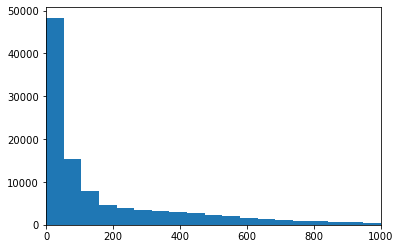

In [4]:
numbers_of_peaks = [len(s.peaks) for s in spectrums]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

In [5]:
np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks))

(5, 37922)

## Remove very small peaks 
- remove all peaks with intensities <0.001 max intensity
- keep at max the highest 1000 peaks

In [6]:
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity

def process_peaks(s):
    s = select_by_relative_intensity(s, intensity_from=0.001)
    s = reduce_to_number_of_peaks(s, n_max=1000)
    return s
    
spectrums = [process_peaks(s) for s in spectrums]

1 1000


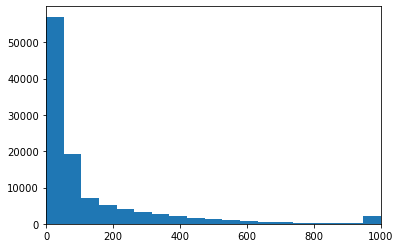

In [10]:
numbers_of_peaks = [len(s.peaks) for s in spectrums]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

print(np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks)))